In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-model4/data_model4.csv
/kaggle/input/predicting-pulsar-starintermediate/pulsar_data_train.csv
/kaggle/input/predicting-pulsar-starintermediate/pulsar_data_test.csv
/kaggle/input/df-atp/df_atp.csv


In [2]:
# __all__ = ["ColorMode", "VisImage", "BinaryClass"]
df = pd.read_csv("../input/data-model4/data_model4.csv", index_col=0)
df_atp = pd.read_csv("../input/df-atp/df_atp.csv", index_col=0)
ps = pd.read_csv("../input/predicting-pulsar-starintermediate/pulsar_data_train.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (12,13,16,17,18,19,25,39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
class prepa:
    
    def __init__(self,dataframe,col=None):
        
        self.df = dataframe
#         if col == None:
#             self.col = df.columns
#         else:
#             self.col = col
    
    def col_nan_errors(self,mode):
        obj_cols = [x for x in self.df.columns[self.df.dtypes.eq(object)]]
        print("You have these columns as object types (thus possibly with errors) : \n", obj_cols)
        
        cols_str = [x for x in obj_cols if type(self.df[x][0]) == str]
        #type(coll)
        
        
        print("The columns object that are string (will not be considered to 'coerce' and you be removed from the correction) are : \n", cols_str)
        
        cols_nan = []
        [cols_nan.append(name) for name,val in self.df.isnull().any().items() if val]
#         cols_nan = pd.Series(cols_nan)
        #display(type(cols))
        ######################cols_nan.drop_duplicates(inplace=True)
        #display(cols)
        print("The columns that have nan values are : \n", cols_nan)
        
        print("Would you like to preserve any of the other columns?\nIf yes, please enter 'y'. Otherwhise 'n'\n")
        ans = input()
        idx1,idx2 = "",""
        col_rem = []
        
        if ans=='y':
            print("Please enter the index of the first and last columns (without space!) you want to REMOVE from the correction and press ENTER\nAlternatively, you can\
            write each one with a comma between")
            ans2 = input()
            if ans2.isdigit():
                idx1 = ans2[0]
                idx2 = ans2[1]
            else:
                col_rem = [x for x in ans2.split(",")]
                
        all_cols = cols_nan + obj_cols
        
        all_cols = pd.Series(all_cols)
        all_cols.drop_duplicates(inplace=True)
        
#         select_cols = []
        if len(col_rem) != 0:
            print("Lenght col_rem != 0")
            select_cols = all_cols.drop([x for x in col_rem])
        else:
            select_cols = cols_nan
            print("select_cols : ", select_cols)
              
        self.df.loc[:, select_cols] = self.df.loc[:, select_cols].apply(pd.to_numeric, errors='coerce')

        self.df = self.df.dropna(axis=1, how="all")
        
        if mode == "m_max":
            for each in select_cols: 
                self.df[each] = self.df[each].fillna(self.df[each].max()) 
        else:
            if mode == "m_min":
                for each in select_cols: 
                    self.df[each] = self.df[each].fillna(self.df[each].min())
        return self.df

In [4]:
import lightgbm as lgb
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt 

class GBM:
    

    def __init__(self,train,valid,test,target):
        self.train = train
        self.valid = valid
        self.test = test
        self.target = target
        self.feature_cols = self.train.columns.drop(self.target)
  
    def train_GBM(self,over,n):


        dtrain = lgb.Dataset(self.train[self.feature_cols], label=self.train[self.target])
        dvalid = lgb.Dataset(self.valid[self.feature_cols], label=self.valid[self.target])
    
        if over:
            param = {'num_leaves': 31, 'objective': 'binary', "max_depth": 3,
             'metric': 'auc', 'seed': 7, 'reg_alpha':0.8, 'reg_lambda':0.8}
            print(f"Regularization : l1 = {param['reg_alpha']}, l2 = {param['reg_lambda']}")
        else:
            param = {'num_leaves': 64, 'objective': 'binary',
             'metric': 'auc', 'seed': 7}
            print(f"No regularization!")
        
        evals_result = {} 
        bst = lgb.train(param, dtrain, num_boost_round=1000, valid_sets=[dvalid,dtrain], 
                    early_stopping_rounds=10, verbose_eval=10, evals_result=evals_result)
        nameModel = "Model " + str(n) +".txt"
        import joblib
        # save model
        joblib.dump(bst, nameModel)
    
        self.evaluate_GBM(bst,evals_result,n)  
        
    def evaluate_GBM(self,bst,evals_result,n):
    
        valid_pred = bst.predict(self.valid[self.feature_cols])
        valid_score = metrics.roc_auc_score(self.valid[self.target], valid_pred)
    
        test_pred = bst.predict(self.test[self.feature_cols])
        test_score = metrics.roc_auc_score(self.test[self.target], test_pred)
    
        print(f"Validation AUC score: {valid_score:.4f}")
        print(f"Test AUC score: {test_score:.4f}")
        if valid_score > 0.95:
            print("\n\nYou're overfitting. Better rerun with parameter 'over' as 'True'. If already set as so\
            it is time to fine tune your model parameters!\n\n")
    
        self.plot(evals_result,valid_pred,bst,n)
    
    def plot(self,evals_result,valid_pred,bst,n):
        
        global conf
        global auc
        global roc
        global y_predictions
        #global n
            
        if evals_result != None:
            acu[n] = evals_result
            fig1 = plt.figure(figsize=(45,10))
        #print('Plot metrics during training... Our metric : ', param["metric"])
        #print("evals_ results : ", evals_result)
            lgb.plot_metric(evals_result, metric='auc',figsize=(35,10))
            plt.xlabel('Iterations',fontsize=20)
            plt.ylabel('auc',fontsize=20)
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            plt.title("AUC during training",fontsize=20)
            plt.legend(fontsize=20)
            plt.show()


            ##### CONFUSION MATRIX
        th = 0.5
        y_pred_class = valid_pred > th
        y_predictions[n] = y_pred_class
        cm = confusion_matrix(self.valid[self.target], y_pred_class)
        tn, fp, fn, tp = cm.ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (tp + fn)
        tnr = tn / (tn + fp)
        tpr = tp / (tp + fn)
        numberModel = n
        conf[n] = {'fpr':f'{fpr:.3f}','fnr': f'{fnr:.3f}', 'tnr' : f'{tnr:.3f}', "tpr": f'{tpr:.3f}'}
        if n > 1 and fpr != 0 and fnr != 0 and tnr != 0 and tpr != 0:
            conf["ratio " + str(n) + "/" + str(n-1)] = {"fp":f'{float(conf[n]["fpr"])/float(conf[n-1]["fpr"]):.3f}', \
                                                        "fn":f'{float(conf[n]["fnr"])/float(conf[n-1]["fnr"]):.3f}', \
                                                        "tn":f'{float(conf[n]["tnr"])/float(conf[n-1]["tnr"]):.3f}', \
                                                        "tp":f'{float(conf[n]["tpr"])/float(conf[n-1]["tpr"]):.3f}'}
        
        fig2 = plt.figure(figsize=(35,10))
        fig2.add_subplot(1,2,1)
        sns.heatmap(cm, annot = True, fmt='d', cmap="Blues", vmin = 0.2,linewidths=.5,annot_kws={"fontsize": 20}); #cbar_kws={"fontsize": 20},annot_kws={"fontsize": 20}
        sns.set(font_scale=2)
        plt.title('Confusion Matrix',fontsize=20)
        plt.ylabel('True Class',fontsize=20)
        plt.xlabel('Predicted Class',fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.text(0.1, 0.3, f' FPR: {fpr:.3f}\n FNR: {fnr:.3f}\n TNR: {tnr:.3f}\n TPR: {tpr:.3f}', style='italic',
        bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5}, fontsize=14)
        
        
        #Print Area Under Curve
        fig2.add_subplot(1,2,2)

        false_positive_rate, recall, thresholds = roc_curve(self.valid[self.target], valid_pred)
        roc_auc = auc(false_positive_rate, recall)
        roc[n] = {'fpr':false_positive_rate,'recall':recall}
        
        plt.title('Receiver Operating Characteristic (ROC)')
        for a in range(1,n+1):
            plt.plot(roc[a]['fpr'], roc[a]['recall'], 'b', label = f'Model {n}')
            
#             plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
            plt.legend(loc='lower right')
            plt.plot([0,1], [0,1], 'r--')
            plt.xlim([0.0,1.0])
            plt.ylim([0.0,1.0])
            plt.ylabel('Recall',fontsize=20)
            plt.xlabel('Fall-out (1-Specificity)',fontsize=20)
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
        
        plt.show()    
        display(conf) 
            


In [5]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

class DNN:
    
    def __init__(self,train,valid,test,target,inp_dim):
        self.train = train
        self.valid = valid
        self.test = test
        self.target = target
        self.inp_dim = inp_dim
        
    def train_DNN(self,n):
        #global n
    
        print("\n\n You are now running a DNN algorithm!\n\n")
        #train,valid, test = get_data_splits(dt)

        X = self.train.drop(self.target,axis=1) #[:,0:60].astype(float)
        Y = self.train[self.target]
    # define model
        model = Sequential()

        model.add(Dense(self.inp_dim, activation='relu'))
        model.add(Dense(60,activation='relu'))#input_dim=60
        model.add(Dense(1, activation='sigmoid'))    
        
        # compile model
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # Fit the model
        history = model.fit(X, Y, epochs=10, batch_size=32, verbose=1)
        
        # evaluate the model
        scores = model.evaluate(X, Y, verbose=1)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        # save model and architecture to single file
        model.save("model.h5")
        print("Saved model to disk")
            
        #### Get validation scores
        X_valid = self.valid.drop(self.target,axis=1)

        from sklearn.preprocessing import MinMaxScaler

        y_pred = model.predict_proba(X_valid)

    #     print("lenght ynew : ", len(y_pred))
    # print("X=%s, Predicted=%s" % (Xnew.iloc[0], ynew[0]))

    #### Plot Accuracy graph:
        #print(history.history.keys())
        fig = plt.figure(figsize=(35,10))
    # history.history['accuracy']
        plt.plot(history.history['accuracy'], color='blue', label='train')

        plt.xlabel('Epochs',fontsize=20)
        plt.ylabel('auc',fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.title("AUC during training",fontsize=20)
        plt.legend(fontsize=20)

        plt.show()

In [6]:
import lightgbm as lgb
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt 

#import binGBM as gbm
#import binDNN as dnn
conf = {}
acu = {}
roc = {}
y_predictions = {}


class BinaryClass:
    
    def __init__(self,dataframe,target=None,feature_cols=None):
        
        self.dataframe = dataframe
#         self.conf = {}
#         self.acu = {}
#         self.roc = {}
#         self.y_predictions = {}
        
        if target == None:
            print("What is your target columns?")
            display(self.dataframe.columns)
            
            ans = str(input())
            while ans not in self.dataframe.columns:
                print("Please, enter a valid column name! Pay attention with spaces!")
                ans = str(input())
            self.target = ans
            self.feature_cols = dataframe.columns.drop(self.target)
        else:
            self.target = target
            self.feature_cols = dataframe.columns.drop(self.target)
        
        self.train, self.valid, self.test = self.get_data_splits(self.dataframe)
        
    def get_data_splits(self,dataframe, valid_fraction=0.1):
        
        valid_fraction = 0.1
        valid_size = int(len(dataframe) * valid_fraction)

        train = dataframe[:-valid_size * 2]
        # valid size == test size, last two sections of the data
        valid = dataframe[-valid_size * 2:-valid_size]
        test = dataframe[-valid_size:]
        print(f"Train size : {len(train)}\nValidation size : {len(valid)}\nTest size : {len(test)}")
        return train, valid, test
    
    def train_models(self,over,n):
        gbm = GBM(self.train,self.valid,self.test,self.target)
#         dnn = DNN()
        
        gbm.train_GBM(over,n)
        print("Lenght of self.featcols = ", len(self.feature_cols))
        print("Do you want to run a DNN algorithm? (y/n)" )
        answer = input()
        if answer == 'y':
            dnn = DNN(self.train,self.valid,self.test,self.target,len(self.feature_cols))
            dnn.train_DNN(n)
        
        

Check first for NaN values:

In [7]:
ps.isnull().any()

 Mean of the integrated profile                  False
 Standard deviation of the integrated profile    False
 Excess kurtosis of the integrated profile        True
 Skewness of the integrated profile              False
 Mean of the DM-SNR curve                        False
 Standard deviation of the DM-SNR curve           True
 Excess kurtosis of the DM-SNR curve             False
 Skewness of the DM-SNR curve                     True
target_class                                     False
dtype: bool

Process all the columns and replace them with the Max ("m_max") value of each column:

In [8]:
ps = prepa(ps).col_nan_errors("m_max")

You have these columns as object types (thus possibly with errors) : 
 []
The columns object that are string (will not be considered to 'coerce' and you be removed from the correction) are : 
 []
The columns that have nan values are : 
 [' Excess kurtosis of the integrated profile', ' Standard deviation of the DM-SNR curve', ' Skewness of the DM-SNR curve']
Would you like to preserve any of the other columns?
If yes, please enter 'y'. Otherwhise 'n'



StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.

Check again for the NaN values:

In [9]:
ps.isnull().any()

 Mean of the integrated profile                  False
 Standard deviation of the integrated profile    False
 Excess kurtosis of the integrated profile        True
 Skewness of the integrated profile              False
 Mean of the DM-SNR curve                        False
 Standard deviation of the DM-SNR curve           True
 Excess kurtosis of the DM-SNR curve             False
 Skewness of the DM-SNR curve                     True
target_class                                     False
dtype: bool

Train & evaluate a Binary Classifier passing the dataframe and the output column name (here is "target_class"). If you don't know yet the name of the target name, leave blank and the algorithm will output the options so to you choose interactevely!

Train size : 10024
Validation size : 1252
Test size : 1252
No regularization!
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.993821	valid_0's auc: 0.96533
[20]	training's auc: 0.99705	valid_0's auc: 0.970985
Early stopping, best iteration is:
[15]	training's auc: 0.994897	valid_0's auc: 0.974372
Validation AUC score: 0.9744
Test AUC score: 0.9645


You're overfitting. Better rerun with parameter 'over' as 'True'. If already set as so            it is time to fine tune your model parameters!




<Figure size 3240x720 with 0 Axes>

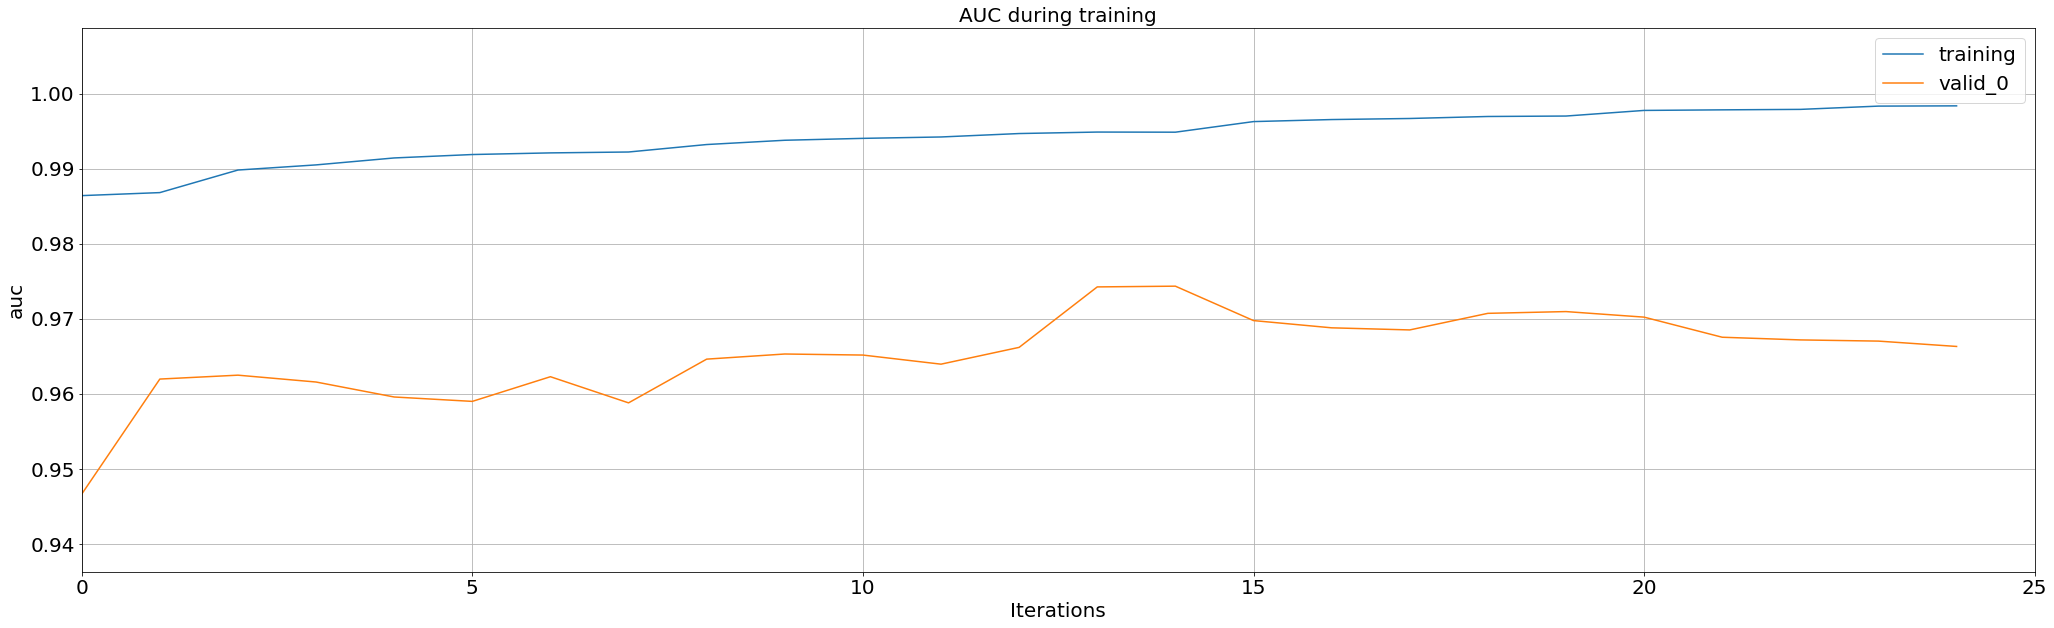

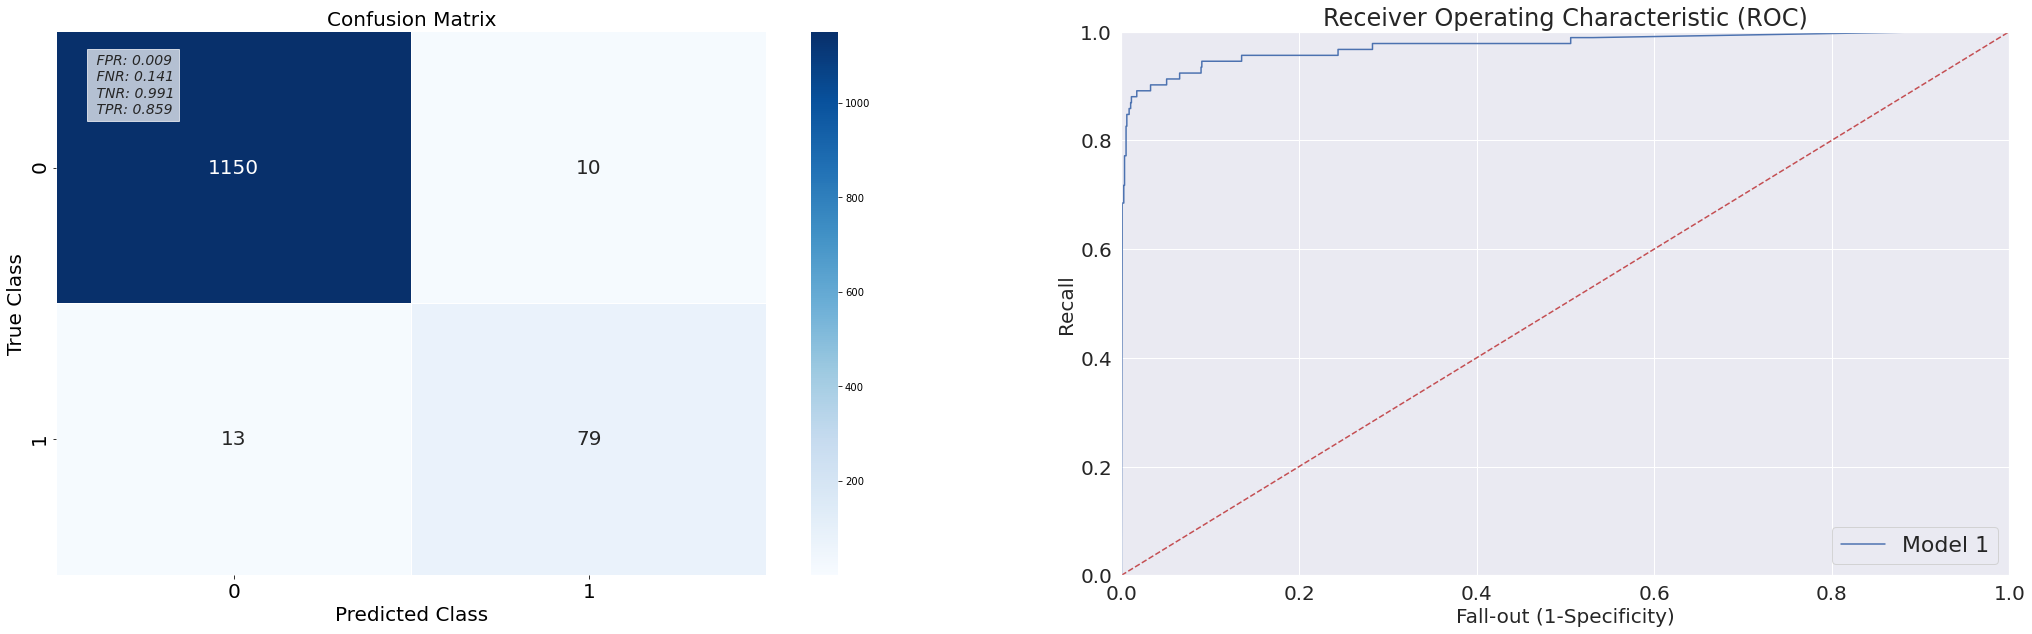

{1: {'fpr': '0.009', 'fnr': '0.141', 'tnr': '0.991', 'tpr': '0.859'}}

Lenght of self.featcols =  8
Do you want to run a DNN algorithm? (y/n)


StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.

In [10]:
"""
dataframe = ps, the dataframe you want to train
target = target_class, the name of your column target!
"""

bc = BinaryClass(ps,'target_class')

"""
over = False, for overfitting or not
n = 1, the model number to get and save the results for further comparison
"""
bc.train_models(False,1)

Try with other parameters to see the plot comparison in the ROC curve and the dictionary (*conf*) of False/Positve cases rates ratio for each model! 

Regularization : l1 = 0.8, l2 = 0.8
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.97287	valid_0's auc: 0.972165
[20]	training's auc: 0.977479	valid_0's auc: 0.975178
[30]	training's auc: 0.980051	valid_0's auc: 0.976593
[40]	training's auc: 0.98255	valid_0's auc: 0.977343
Early stopping, best iteration is:
[34]	training's auc: 0.980744	valid_0's auc: 0.977441
Validation AUC score: 0.9774
Test AUC score: 0.9738


You're overfitting. Better rerun with parameter 'over' as 'True'. If already set as so            it is time to fine tune your model parameters!




<Figure size 3240x720 with 0 Axes>

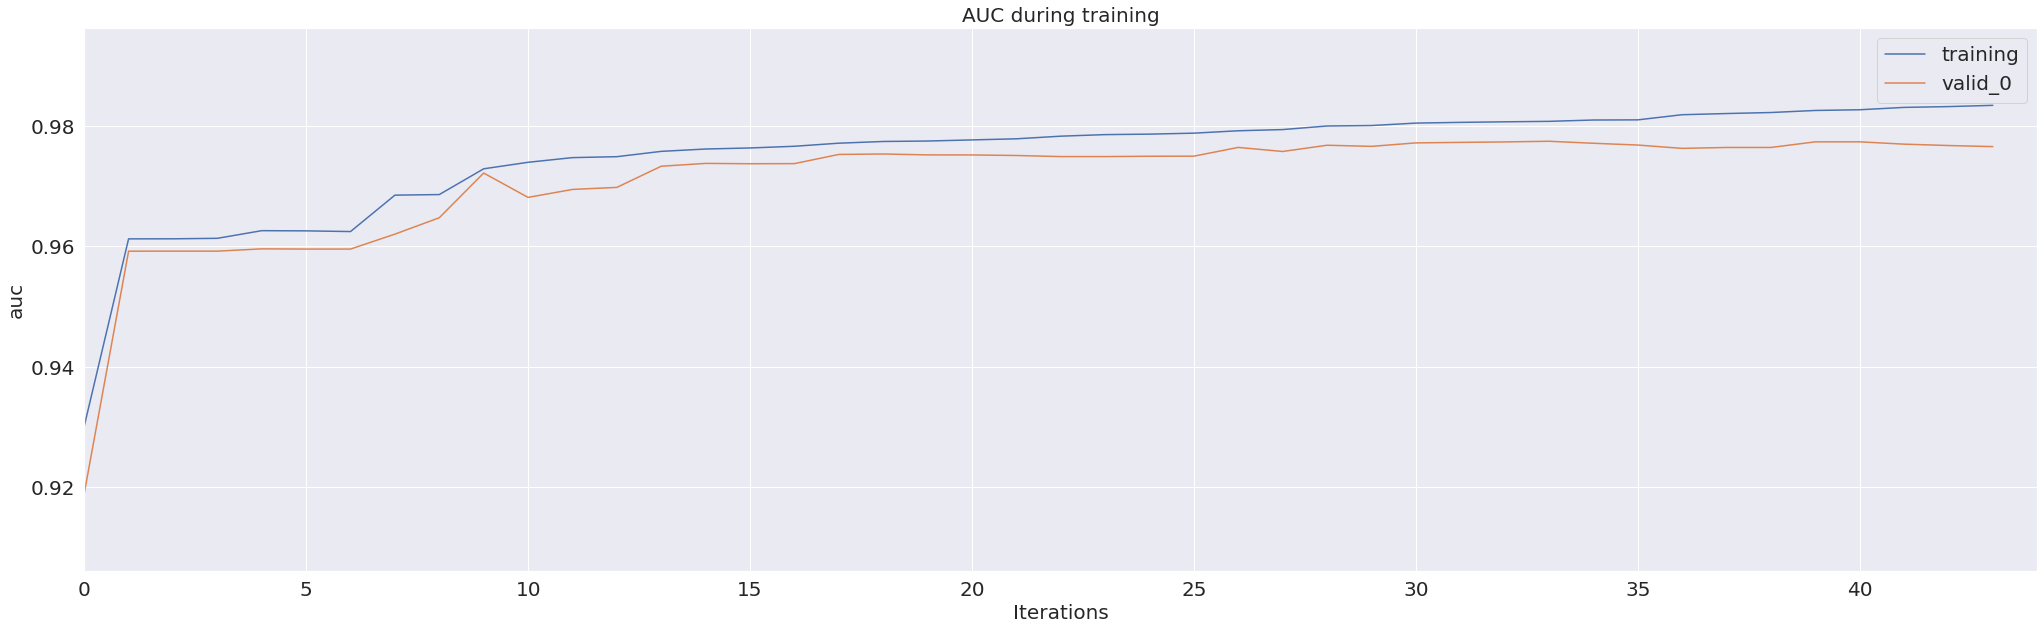

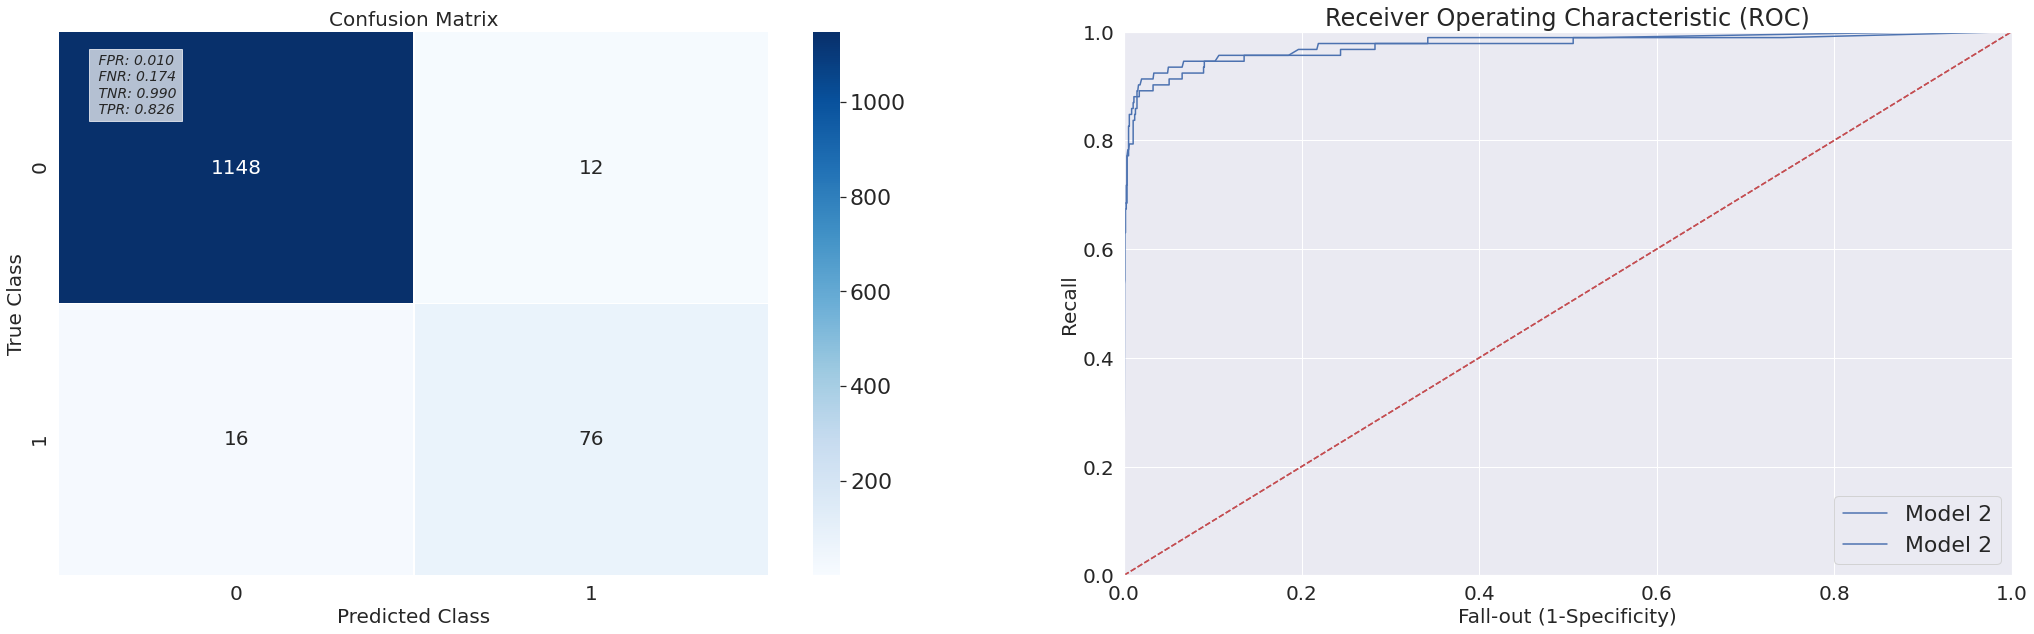

{1: {'fpr': '0.009', 'fnr': '0.141', 'tnr': '0.991', 'tpr': '0.859'},
 2: {'fpr': '0.010', 'fnr': '0.174', 'tnr': '0.990', 'tpr': '0.826'},
 'ratio 2/1': {'fp': '1.111', 'fn': '1.234', 'tn': '0.999', 'tp': '0.962'}}

Lenght of self.featcols =  8
Do you want to run a DNN algorithm? (y/n)


StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.

In [11]:
bc.train_models(True,2)